### Author members

1. Jaydeep Samanta

#### The code executes to the end without any error

### Took inspiration from multiple sources as cited below

1. https://goodboychan.github.io/python/reinforcement_learning/pytorch/udacity/2021/05/12/REINFORCE-CartPole.html

2. https://gist.github.com/karpathy/a4166c7fe253700972fcbc77e4ea32c5

3. https://github.com/simoninithomas/Deep_reinforcement_learning_Course/tree/master/Policy%20Gradients/Cartpole

4. Book: Deep Reinforcement Learning Hands-On Apply modern RL methods, with deep Q-networks, value iteration, policy gradients, TRPO,... (Maxim Lapan) (Chapter 9)

## REINFORCE
---
In this notebook, we will implement the REINFORCE agent on the CartPole-v0 environment provided by OpenAI Gym. To summarize, the REINFORCE method is a Monte Carlo variant of the policy gradient algorithm used in reinforcement learning. The agent gathers information about an episode's course from current policies. Typically, this policy is determined by the policy parameter denoted by theta. REINFORCE, on the other hand, is an acronym for "REward Increment = Nonnegative Factor Offset Reinforcement Characteristic Eligibility."

In [1]:
# Import necessary packages

import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

# Pytorch utils
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
torch.manual_seed(0)

import base64, io

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display 
import glob

In [2]:
# Checking if cuda enabled device is available

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Instantiate the Environment and Agent

CartPole environment is very simple. It has discrete action space (2) and 4 dimensional state space. 

Actions: Left, Right

States: Cart Position, Cart Velocity, Pole Angle, Pole Velocity

In [3]:
# Creating Cartpole environment
env = gym.make('CartPole-v0')
env.seed(0)

# Environment hyperparameters
print('observation space:', env.observation_space)
print('action space:', env.action_space)

observation space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
action space: Discrete(2)


### Policy Definition
In contrast to the value-based strategy, the policy-based method produces the probability of each action. It may be referred to as policy. Thus, the output layer's activation function will be softmax, not ReLU.

In [4]:
class Policy(nn.Module):
    def __init__(self, state_size=4, action_size=2, hidden_size=32):
        super(Policy, self).__init__()
        # Creating 2 fully connected sequential layers 
        # Since cartpole has discrete action space
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)

    # Forward takes the current state as input and ouputs the predicted value
    # Here softmax is used for the final output    
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = self.fc2(x)
        # we just consider 1 dimensional probability of action
        return F.softmax(x, dim=1)
    
    # define actions
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        # Apply categorical distribution to the model outputs and sample actions from it
        model = Categorical(probs)
        action = model.sample()
        return action.item(), model.log_prob(action)

### REINFORCE

In [5]:
# Training Hyperparamters
# max_episodes = 1000
# max_trajectory = 1000
# gamma = 0.99 # Discount rate
def reinforce(policy, optimizer, n_episodes=1000, max_t=1000, gamma=0.99, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    # Loop through each episode
    for e in range(1, n_episodes):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        # Collect trajectory
        for t in range(max_t):
            # Sample the action from current policy
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            # Simulate action
            state, reward, done, _ = env.step(action)
            # reward received at last step
            rewards.append(reward)
            # If game is over (done) then break
            if done:
                break
        # Calculate total expected reward
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        # Recalculate the total reward applying discounted factor
        discounts = [gamma ** i for i in range(len(rewards) + 1)]
        R = sum([a * b for a,b in zip(discounts, rewards)])
        
        # Calculate the loss 
        policy_loss = []
        for log_prob in saved_log_probs:
            # Note that we are using Gradient Ascent, not Descent. So we need to calculate it with negative rewards.
            policy_loss.append(-log_prob * R)
        # After that, we concatenate whole policy loss in 0th dimension
        policy_loss = torch.cat(policy_loss).sum()
        
        # Backpropagation
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        if e % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(e, np.mean(scores_deque)))
        if np.mean(scores_deque) >= 195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(e - 100, np.mean(scores_deque)))
            break
    return scores

### Create Policy

In [6]:
policy = Policy().to(device)

### Optimizer function

Using ADAM optimizer with a learning rate of 0.01

In [7]:
optimizer = optim.Adam(policy.parameters(), lr=0.01)

### Running the REINFORCE algorithm and recording the scores

In [8]:
scores = reinforce(policy, optimizer, n_episodes=10000)

Episode 100	Average Score: 36.06
Episode 200	Average Score: 65.88
Episode 300	Average Score: 52.26
Episode 400	Average Score: 62.58
Episode 500	Average Score: 173.71
Episode 600	Average Score: 111.98
Episode 700	Average Score: 111.96
Episode 800	Average Score: 178.06
Episode 900	Average Score: 78.99
Episode 1000	Average Score: 137.25
Episode 1100	Average Score: 143.80
Episode 1200	Average Score: 183.85
Environment solved in 1116 episodes!	Average Score: 195.71


### Plot the learning progress

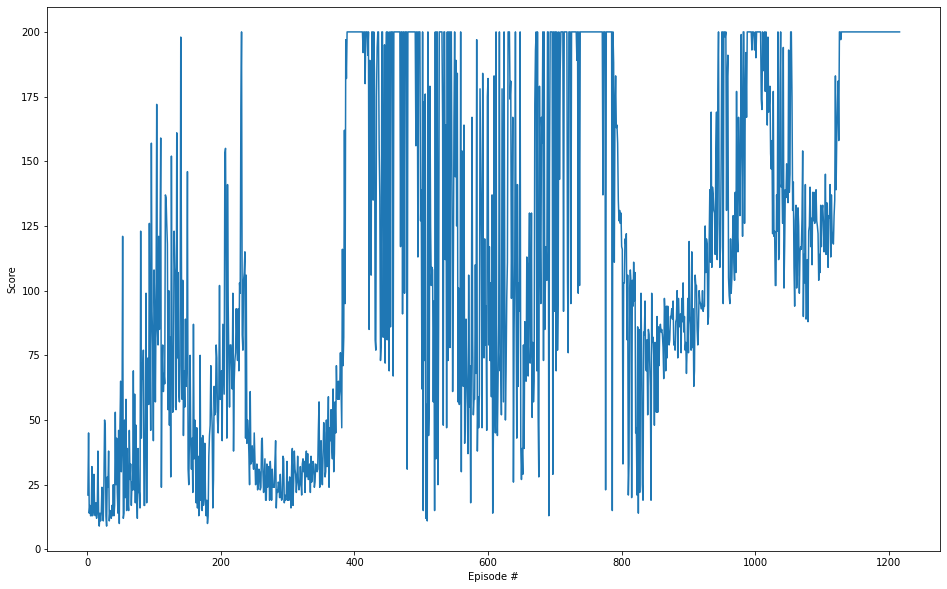

In [9]:
# plot the scores
plt.figure(figsize=(16,10))
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Summary

Our final result demonstrates spiky, but nonetheless learning. The spikes on the plot show the mapping process our algorithm was conducting. We can see that despite occasional low situated spikes overall, each substantial result on average was situated higher. Although the upward trend seems to be pretty slow, we also can observe significantly high values of cart balancing the pole for 195+ steps in-between 400-800 episodes. This is also where the biggest difference in high/low scores is present. What also is worth noting is that within less than 200 episodes the cart has managed to achieve the highest score. At around 1150 episode, the cart has learned to perfectly play the game and after that point in time, it doesn’t score lower than the maximum score.  

When we compare our result with the result of the source code author, we can see similar features in the graph. It’s definitely worth mentioning that in the early stages, his algorithm scores lower than ours but the learning curve is more rapid and there are less frequent valleys of low performance. However, in the late stage our model almost never drops below 100 steps, unlike his model which after 900 steps was still capable of getting less than 25 steps. With that in mind in the final version he achieved a perfect constant score at around 1070 episodes, where this took us slightly longer, around 1116 episodes.